# Percepton

Generator for this dataset is taken from the project:
https://github.com/matthewearl/deep-anpr

In [11]:
%matplotlib inline
import random
import time
import numpy as np
import pandas as pd
from sklearn import cross_validation
from skimage import io
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import tensorflow as tf
from pylab import rcParams

DATA_PATH = '../data/mearl/'

## Import data

Data is stored in csv file. Images are saved as PNG files.

Data will be loaded into the following variables:
  * X - Images, (num_of_images, image_height, image_width) Tensor
  * Y - Labels, (num_of_images, 4) left, top, right, bottom 

In [2]:
def load_image(fname):
    return io.imread(DATA_PATH + fname) / 256.

df = pd.read_csv(DATA_PATH + 'train.csv')
img = load_image(df.iloc[0].image)
print('Image dimension: ' + str(img.shape))
df.head()

Image dimension: (64, 128)


,image,plate,left,top,right,bottom
0,00000000_XR30PGY.png,XR30PGY,44,28,85,38
1,00000001_PK69KBA.png,PK69KBA,70,27,116,37
2,00000002_VH93KAI.png,VH93KAI,56,26,100,37
3,00000003_AD11AAS.png,AD11AAS,43,28,85,40
4,00000004_WO98LGQ.png,WO98LGQ,83,19,123,27


Basic image information

In [3]:
xs = [load_image(fname) for fname in df['image']]
X = np.array(xs)
Y = df[['left', 'top', 'right', 'bottom']].as_matrix()
print('Images shape: ' + str(X.shape))
print('Labels shape: ' + str(Y.shape))

Images shape: (10000, 64, 128)
Labels shape: (10000, 4)


### Show sample images

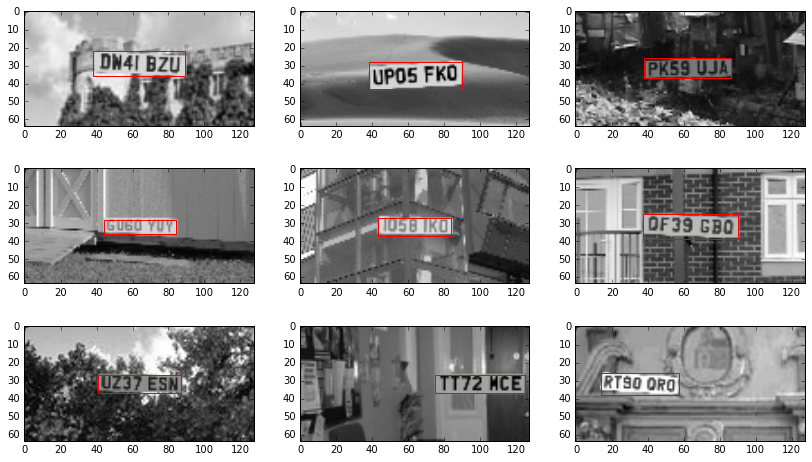

In [6]:
def show_image(image, labels):
    rect = Rectangle((labels[0], labels[1]), labels[2]-labels[0], labels[3]-labels[1], edgecolor='r', fill=False)
    plt.imshow(image)
    gca = plt.gca()
    gca.add_patch(rect)
    
def plot_random_images(images, labels):
    rcParams['figure.figsize'] = 14, 8
    plt.gray()
    fig = plt.figure()
    n = images.shape[0]
    for i in range(9):
        fig.add_subplot(3, 3, i+1)
        index = random.randint(0, n)
        show_image(images[index], labels[index])
    plt.show()    
    
plot_random_images(X, Y)    

## Build Tensorflow neural net

### Define loss function

We will optimize mean square error over all predictions.

$$MSE = \frac{1}{n} \sum_{i=1}^{n}{(\hat{y_i} - y_i)^2}$$

In [7]:
def mse(expected, predicted):
    se = tf.square(expected - predicted)
    return tf.reduce_mean(se)

Define dataset helper for batch processing

In [10]:
class Dataset:

    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self._epochs_completed = 0
        self._index_in_epoch = 0
        self._num_examples = X.shape[0]

    def next_batch(self, batch_size=20):
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self._num_examples:
            self._epochs_completed += 1
            # Shuffle the data
            perm = np.arange(self._num_examples)
            np.random.shuffle(perm)
            self.X = self.X[perm]
            self.Y = self.Y[perm]
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch
        return self.X[start:end], self.Y[start:end]

    def epoch_completed(self):
        return self._epochs_completed

### Build model

In [9]:
HIDDEN_1_SIZE = 100
PIXEL_COUNT = X.shape[1] * X.shape[2]
LABEL_COUNT = Y.shape[1]
# Create placeholders for image data and expected point positions
x_placeholder = tf.placeholder(tf.float32, shape=[None, PIXEL_COUNT])
y_placeholder = tf.placeholder(tf.float32, shape=[None, LABEL_COUNT])

# Build neural network
def build_model(xs):
    W1 = tf.Variable(tf.truncated_normal([PIXEL_COUNT, HIDDEN_1_SIZE], stddev=0.1))
    b1 = tf.Variable(tf.constant(0.1, shape=[HIDDEN_1_SIZE]))
    hidden1 = tf.nn.relu(tf.matmul(xs, W1) + b1)
    W2 = tf.Variable(tf.truncated_normal([HIDDEN_1_SIZE, LABEL_COUNT], stddev=0.1))
    b2 = tf.Variable(tf.constant(0.1, shape=[LABEL_COUNT]))
    return tf.matmul(hidden1, W2) + b2

# Define loss function
model = build_model(x_placeholder)
loss = mse(y_placeholder, model)

### Train

In [34]:
X2 = np.reshape(X, (X.shape[0], X.shape[1]*X.shape[2]))
Y2 = Y / (64, 32, 64, 32) - 1
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X2, Y2, train_size=0.8)
dataset = Dataset(X_train, Y_train)
EPOCH = 1e4
with tf.Session() as session:
    start_time = time.time()
    session.run(tf.initialize_all_variables())
    train_step = tf.train.GradientDescentOptimizer(5e-3).minimize(loss)
    last_epoch = -1
    while dataset.epoch_completed() < EPOCH:
        (batch_x, batch_y) = dataset.next_batch(20)
        train_step.run(feed_dict={x_placeholder: batch_x, y_placeholder: batch_y})
        if dataset.epoch_completed() > last_epoch and dataset.epoch_completed() % 1000 == 0:
            score_train = loss.eval(feed_dict={x_placeholder: X_train, y_placeholder: Y_train})
            score_test = loss.eval(feed_dict={x_placeholder: X_test, y_placeholder: Y_test})
            print('Epoch: %d, Score: (train=%f, test=%f)' % (dataset.epoch_completed(), score_train, score_test))
            last_epoch = dataset.epoch_completed()
    Y2_train = model.eval(feed_dict={x_placeholder: X_train})
    Y2_test = model.eval(feed_dict={x_placeholder: X_test})
    score = loss.eval(feed_dict={x_placeholder: X2, y_placeholder: Y})
    print('Finished in %d seconds with score: %f' % (time.time()-start_time, score))  
    print(Y2_test)

Epoch: 0, Score: (train=3.999229, test=4.028058)
Epoch: 1000, Score: (train=0.027676, test=0.058928)
Epoch: 2000, Score: (train=0.015879, test=0.077634)
Epoch: 3000, Score: (train=0.009765, test=0.098216)
Epoch: 4000, Score: (train=0.007187, test=0.113521)
Epoch: 5000, Score: (train=0.005816, test=0.124776)
Epoch: 6000, Score: (train=0.005051, test=0.134098)
Epoch: 7000, Score: (train=0.004572, test=0.142079)
Epoch: 8000, Score: (train=0.004206, test=0.148628)
Epoch: 9000, Score: (train=0.003944, test=0.154284)
Epoch: 10000, Score: (train=0.003743, test=0.159108)
Finished in 18880 seconds with score: 2915.605957
[[-1.4825058  -0.19571957 -0.81897914  0.1341674 ]
 [-0.27656722 -0.20301807  0.44505391  0.15233509]
 [-0.74663866 -0.69793487 -0.03220341 -0.34814674]
 ..., 
 [-0.51157844  0.20970666  0.22779638  0.57588023]
 [-0.32195437 -0.07876948  0.40292823  0.27908105]
 [-0.39060459  0.65388876  0.32933822  0.99776971]]


### Show some sample predictions

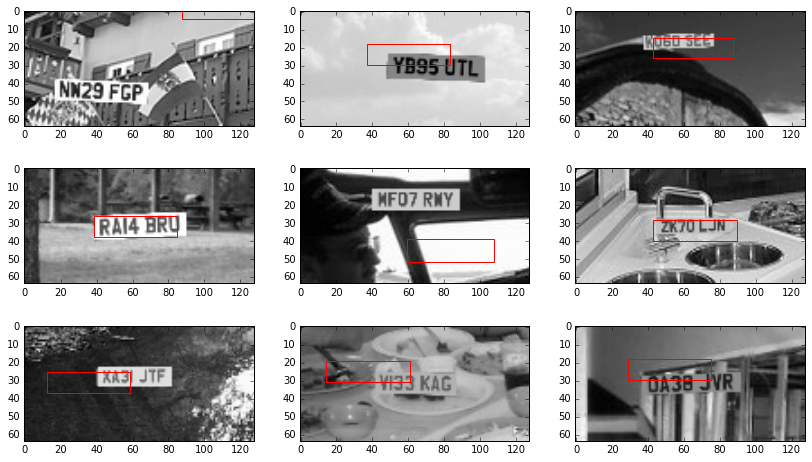

In [35]:
xs = np.reshape(X_test, (X_test.shape[0], X.shape[1], X.shape[2]))
plot_random_images(xs, (Y2_test+1) * (64, 32, 64, 32))

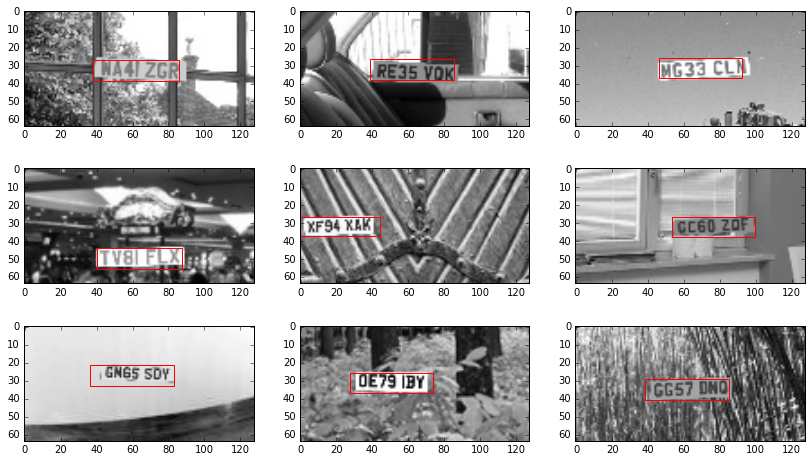

In [36]:
xs = np.reshape(X_train, (X_train.shape[0], X.shape[1], X.shape[2]))
plot_random_images(xs, (Y2_train+1) * (64, 32, 64, 32))